In [1]:
import copy
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, minmax_scale

from main_event import prepare_event_data, prepare_json_event_data
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_player_ball_distances,
    get_n_smallest_indices_sorted,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [5]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


## Tracking for individual Players Visualization

AttributeError: 'PreProcessing' object has no attribute '_colors'

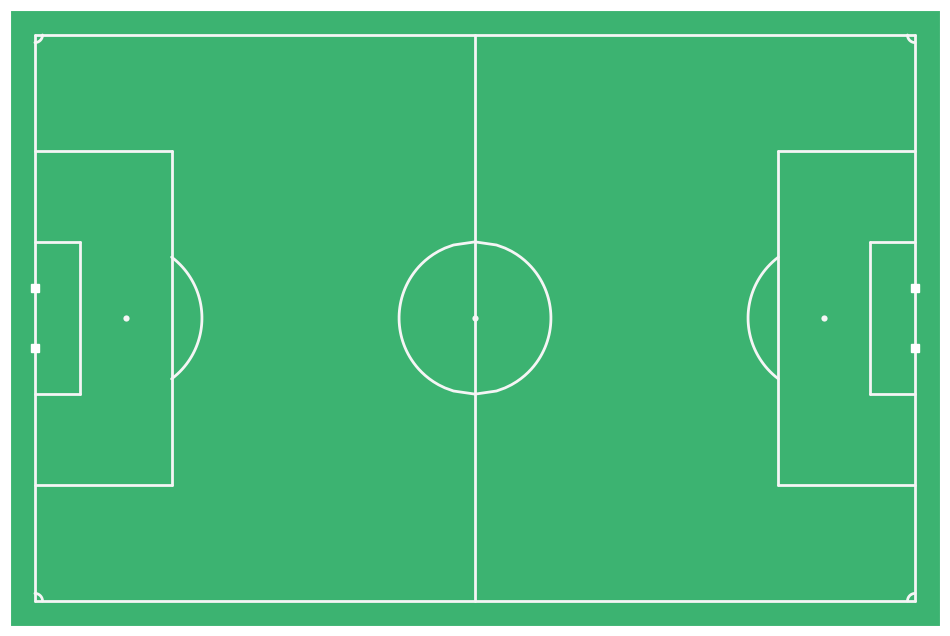

In [6]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_1_data.loc[143615:143625], players=[16], sides=["Away"], plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [6]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [7]:
vel_acc_game_1_data = calculate_velocity_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_direction(game_2_data)

In [8]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.151215,1.134248
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,1.134129
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,-0.157769,0.019121,-0.446106,0.015201,-0.937163,0.029611,-0.707711,0.415521,1.767602
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-1.629552,0.011560,-0.376490,0.022103,-2.332199,0.029100,-0.925577,0.417319,3.041984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,-2.944197,0.002704,-0.982794,0.013613,-2.343208,0.017509,-2.969402,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,3.017238,0.011319,-0.110657,0.014346,-2.294544,0.022407,-2.950762,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,-2.010639,0.007906,-0.965252,0.013829,-2.279423,0.009100,-2.492597,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,-1.570796,0.013440,-0.811708,0.015004,-1.755121,0.007754,-1.933341,0.000000,0.000000


In [9]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,1.570796,0.010000,2.498092,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,1.570796,0.006951,2.483704,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,1.570796,0.016623,2.929449,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,1.570796,0.009014,0.588003,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [11]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,1.570796,0.010000,2.498092,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,1.570796,0.006951,2.483704,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,1.570796,0.016623,2.929449,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,1.570796,0.009014,0.588003,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [13]:
game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [14]:
# game_1_player_data = game_1_data.iloc[:, 3:]
# game_2_player_data = game_2_data.iloc[:, 3:]

# Classification

In [15]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)

In [16]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [17]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [18]:
valid_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[valid_indices]
y_1 = game_1_event.loc[valid_indices]

In [19]:
valid_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[valid_indices]
y_2 = game_2_event.loc[valid_indices]

In [20]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction
3,0.00114,0.48238,0.004500,1.570796,0.32648,0.65322,0.000000,0.000000,0.33701,0.48863,...,0.000000,0.000000,0.37833,0.27383,0.000000,0.000000,0.53716,0.42556,1.123138,1.134129
4,0.00121,0.48238,0.001750,1.570796,0.32622,0.65317,0.006619,-1.760785,0.33687,0.48988,...,0.015201,-0.937163,0.37756,0.27473,0.029611,-0.707711,0.55346,0.42231,0.415521,1.767602
5,0.00129,0.48238,0.002000,1.570796,0.32597,0.65269,0.013530,-2.661418,0.33664,0.49018,...,0.022103,-2.332199,0.37663,0.27543,0.029100,-0.925577,0.55512,0.40570,0.417319,3.041984
6,0.00140,0.48238,0.002750,1.570796,0.32581,0.65159,0.027789,-2.997151,0.33637,0.48966,...,0.030026,-2.456449,0.37557,0.27673,0.041934,-0.684052,0.55677,0.38909,0.417294,3.042580
7,0.00140,0.48238,0.000000,0.000000,0.32570,0.65037,0.030624,-3.051672,0.33624,0.48919,...,0.028286,-2.343695,0.37439,0.27751,0.035362,-0.986715,0.55842,0.37248,0.417294,3.042580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.007425,-0.785398,0.25147,0.54818,0.013759,-1.607144,0.47196,0.44820,...,0.022553,-0.627981,0.29910,0.56158,0.049961,-1.374382,0.08382,0.62709,0.126932,-2.462238
143615,0.87601,0.48911,0.007250,-0.761013,0.25096,0.54821,0.012772,-1.512041,0.47157,0.44844,...,0.021652,-0.629645,0.29717,0.56196,0.049176,-1.376392,0.08062,0.62314,0.127089,-2.460707
143616,0.87583,0.48933,0.007106,-0.685730,0.25045,0.54823,0.012760,-1.531601,0.47120,0.44872,...,0.021250,-0.643501,0.29526,0.56233,0.048638,-1.379449,0.07743,0.61919,0.126932,-2.462238
143617,0.87564,0.48954,0.007080,-0.735440,0.24996,0.54830,0.012374,-1.428899,0.47084,0.44899,...,0.023110,-0.545985,0.29335,0.56268,0.048545,-1.389561,0.07423,0.61523,0.127283,-2.461944


# New Dataset

In [21]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [22]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [23]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns

In [24]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [25]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)
# game_3_data.iloc[:, 24:-2] = -1 * game_3_data.iloc[:, 24:-2]
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [26]:
vel_acc_game_3_data = calculate_velocity_direction(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,-2.844360,0.131646,-2.983312,0.004507,-2.553590,0.007603,-1.405648,0.0,0.0
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-2.638749,0.024251,-3.131284,0.010753,0.950547,0.005590,-1.107149,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-2.214297,0.035672,-3.043319,0.014182,0.860258,0.024079,-2.921798,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,-2.903757,0.005056,2.992703,0.012415,1.134169,0.009763,-2.909036,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,-1.540503,0.012260,-2.787595,0.006828,-2.727086,0.016900,-1.060824,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,-1.299849,0.014346,-2.417845,0.013647,-0.147078,0.027933,-0.798056,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,-0.996491,0.019416,-2.173084,0.021588,-0.494726,0.035588,-1.151145,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,-1.605747,0.026450,-0.932966,0.036566,-0.445301,0.034792,-1.441094,0.0,0.0


In [27]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,-2.844360,0.131646,-2.983312,0.004507,-2.553590,0.007603,-1.405648,0.0,0.0
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-2.638749,0.024251,-3.131284,0.010753,0.950547,0.005590,-1.107149,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-2.214297,0.035672,-3.043319,0.014182,0.860258,0.024079,-2.921798,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,-2.903757,0.005056,2.992703,0.012415,1.134169,0.009763,-2.909036,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,-1.540503,0.012260,-2.787595,0.006828,-2.727086,0.016900,-1.060824,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,-1.299849,0.014346,-2.417845,0.013647,-0.147078,0.027933,-0.798056,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,-0.996491,0.019416,-2.173084,0.021588,-0.494726,0.035588,-1.151145,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,-1.605747,0.026450,-0.932966,0.036566,-0.445301,0.034792,-1.441094,0.0,0.0


In [28]:
game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").round(4).fillna(0)
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction
1,0.8472,0.5286,0.0,0.0,0.6527,0.2479,0.0000,0.0000,0.6652,0.4656,...,0.0000,0.0000,0.4886,0.3636,0.0000,0.0000,0.5012,0.4872,0.0,0.0
2,0.8472,0.5286,0.0,0.0,0.6523,0.2451,0.0704,-3.0097,0.6648,0.4655,...,0.0045,-2.5536,0.4883,0.3636,0.0076,-1.4056,0.5012,0.4872,0.0,0.0
3,0.8472,0.5286,0.0,0.0,0.6520,0.2439,0.0326,-2.8780,0.6647,0.4654,...,0.0108,0.9505,0.4881,0.3637,0.0056,-1.1071,0.5012,0.4872,0.0,0.0
4,0.8472,0.5286,0.0,0.0,0.6517,0.2429,0.0259,-2.8381,0.6646,0.4649,...,0.0142,0.8603,0.4879,0.3628,0.0241,-2.9218,0.5012,0.4872,0.0,0.0
5,0.8472,0.5286,0.0,0.0,0.6514,0.2425,0.0112,-2.5474,0.6645,0.4647,...,0.0124,1.1342,0.4878,0.3624,0.0098,-2.9090,0.5012,0.4872,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.1199,0.5178,0.0,0.0,0.4781,0.4541,0.0175,-0.0428,0.4969,0.7731,...,0.0068,-2.7271,0.8079,0.2711,0.0169,-1.0608,0.8921,0.5048,0.0,0.0
143758,0.1199,0.5178,0.0,0.0,0.4779,0.4552,0.0288,-0.1923,0.4970,0.7743,...,0.0136,-0.1471,0.8071,0.2718,0.0279,-0.7981,0.8921,0.5048,0.0,0.0
143759,0.1199,0.5178,0.0,0.0,0.4774,0.4571,0.0482,-0.2249,0.4969,0.7756,...,0.0216,-0.4947,0.8058,0.2724,0.0356,-1.1511,0.8921,0.5048,0.0,0.0
143760,0.1199,0.5178,0.0,0.0,0.4767,0.4595,0.0623,-0.3014,0.4968,0.7764,...,0.0366,-0.4453,0.8044,0.2726,0.0348,-1.4411,0.8921,0.5048,0.0,0.0


In [29]:
# game_3_player_data = game_3_data.iloc[:, 2:]
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction
1,0.8472,0.5286,0.0,0.0,0.6527,0.2479,0.0000,0.0000,0.6652,0.4656,...,0.0000,0.0000,0.4886,0.3636,0.0000,0.0000,0.5012,0.4872,0.0,0.0
2,0.8472,0.5286,0.0,0.0,0.6523,0.2451,0.0704,-3.0097,0.6648,0.4655,...,0.0045,-2.5536,0.4883,0.3636,0.0076,-1.4056,0.5012,0.4872,0.0,0.0
3,0.8472,0.5286,0.0,0.0,0.6520,0.2439,0.0326,-2.8780,0.6647,0.4654,...,0.0108,0.9505,0.4881,0.3637,0.0056,-1.1071,0.5012,0.4872,0.0,0.0
4,0.8472,0.5286,0.0,0.0,0.6517,0.2429,0.0259,-2.8381,0.6646,0.4649,...,0.0142,0.8603,0.4879,0.3628,0.0241,-2.9218,0.5012,0.4872,0.0,0.0
5,0.8472,0.5286,0.0,0.0,0.6514,0.2425,0.0112,-2.5474,0.6645,0.4647,...,0.0124,1.1342,0.4878,0.3624,0.0098,-2.9090,0.5012,0.4872,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.1199,0.5178,0.0,0.0,0.4781,0.4541,0.0175,-0.0428,0.4969,0.7731,...,0.0068,-2.7271,0.8079,0.2711,0.0169,-1.0608,0.8921,0.5048,0.0,0.0
143758,0.1199,0.5178,0.0,0.0,0.4779,0.4552,0.0288,-0.1923,0.4970,0.7743,...,0.0136,-0.1471,0.8071,0.2718,0.0279,-0.7981,0.8921,0.5048,0.0,0.0
143759,0.1199,0.5178,0.0,0.0,0.4774,0.4571,0.0482,-0.2249,0.4969,0.7756,...,0.0216,-0.4947,0.8058,0.2724,0.0356,-1.1511,0.8921,0.5048,0.0,0.0
143760,0.1199,0.5178,0.0,0.0,0.4767,0.4595,0.0623,-0.3014,0.4968,0.7764,...,0.0366,-0.4453,0.8044,0.2726,0.0348,-1.4411,0.8921,0.5048,0.0,0.0


In [30]:
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [31]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [32]:
valid_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[valid_indices]
y_3 = game_3_event.loc[valid_indices]

assert X_3.shape[0] == y_3.shape[0]

In [33]:
X_3

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction
384,0.8490,0.5088,0.0124,2.0525,0.6328,0.1832,0.0095,-2.6779,0.7376,0.3957,...,0.0347,2.2489,0.4982,0.3676,0.0233,1.1023,0.4972,0.4853,0.0106,-2.5405
385,0.8494,0.5086,0.0117,1.9672,0.6327,0.1828,0.0112,-2.7279,0.7377,0.3961,...,0.0351,2.1944,0.4990,0.3681,0.0238,1.0790,0.4988,0.4870,0.0585,0.7582
386,0.8499,0.5083,0.0142,2.1294,0.6325,0.1826,0.0077,-2.4720,0.7379,0.3965,...,0.0359,2.1781,0.4999,0.3685,0.0236,1.1450,0.5021,0.4905,0.1193,0.7409
387,0.8503,0.5082,0.0126,1.9365,0.6323,0.1822,0.0096,-2.6547,0.7381,0.3969,...,0.0370,2.1738,0.5008,0.3689,0.0244,1.1484,0.5053,0.4941,0.1191,0.7394
388,0.8508,0.5080,0.0123,1.9248,0.6321,0.1819,0.0095,-2.6192,0.7382,0.3974,...,0.0377,2.1294,0.5017,0.3693,0.0252,1.1516,0.5085,0.4976,0.1191,0.7423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.1199,0.5178,0.0000,0.0000,0.4281,0.4874,0.0173,2.1508,0.4386,0.7978,...,0.0080,1.3182,0.7547,0.2033,0.0330,2.1946,0.8771,0.5331,0.1522,2.6765
143530,0.1199,0.5178,0.0000,0.0000,0.4287,0.4870,0.0178,2.1160,0.4390,0.7972,...,0.0082,1.3258,0.7558,0.2026,0.0326,2.1652,0.8798,0.5277,0.1521,2.6779
143531,0.1199,0.5178,0.0000,0.0000,0.4293,0.4866,0.0186,2.2035,0.4393,0.7965,...,0.0084,1.2679,0.7569,0.2018,0.0347,2.2129,0.8826,0.5222,0.1522,2.6765
143532,0.1199,0.5178,0.0000,0.0000,0.4299,0.4862,0.0185,2.1738,0.4396,0.7960,...,0.0080,1.4773,0.7580,0.2010,0.0345,2.1809,0.8853,0.5168,0.1522,2.6765


### Adding which team has the ball using distance metrics

In [34]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[X_1.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[X_1.index, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[X_1.index, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[X_2.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[X_2.index, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[X_2.index, "P_11_velocity":]
game_3_players, game_3_ball, game_3_vel_acc = vel_acc_game_3_data.loc[X_3.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_3_data.loc[X_3.index, "Ball-x":"Ball-y"], vel_acc_game_3_data.loc[X_3.index, "P_11_velocity":]

In [35]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data.loc[X_1.index],
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
6,0.24,0.563151,0.349641,0.242261,0.249360,0.295297,0.365688,0.166072,0.177541,0.208422,...,0.179660,0.142050,0.393339,0.269474,0.102840,0.287690,0.043790,0.558136,0.361370,0.213209
7,0.28,0.567758,0.362466,0.250968,0.248928,0.287334,0.380255,0.176221,0.173689,0.196685,...,0.162456,0.149593,0.408004,0.282869,0.105487,0.302437,0.059987,0.574458,0.347387,0.207090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,5744.56,0.804350,0.185293,0.427381,0.428353,0.056973,0.095513,0.184103,0.519533,0.082591,...,0.114894,0.030264,0.086602,0.363107,0.154489,0.155523,0.009879,0.381254,0.393613,0.225027
143615,5744.60,0.806604,0.186092,0.428208,0.430656,0.060635,0.092409,0.186681,0.518725,0.080450,...,0.116965,0.026288,0.089510,0.362792,0.151052,0.156188,0.015445,0.378841,0.394586,0.225026
143616,5744.64,0.808892,0.187006,0.429086,0.432985,0.064416,0.090174,0.189370,0.517919,0.078450,...,0.119181,0.023143,0.092503,0.362527,0.147764,0.156886,0.021004,0.376427,0.395626,0.225129
143617,5744.68,0.811206,0.188044,0.430041,0.435382,0.068212,0.090508,0.192103,0.517189,0.076664,...,0.121536,0.021172,0.095605,0.362424,0.144597,0.157611,0.026631,0.374041,0.396738,0.225333


In [36]:
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data.loc[X_2.index],
    player_data=game_2_players,
    ball_data=game_2_ball
)
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
146,5.84,0.496703,0.342948,0.277024,0.236026,0.373352,0.313091,0.180737,0.153203,0.257618,...,0.300610,0.114074,0.135304,0.244139,0.380443,0.000552,0.156475,0.510173,0.154591,0.171414
147,5.88,0.495560,0.339008,0.274342,0.236814,0.377921,0.307608,0.177571,0.154230,0.262085,...,0.306740,0.118177,0.130822,0.238153,0.385671,0.006124,0.150416,0.503450,0.156447,0.167461
148,5.92,0.494714,0.335354,0.272058,0.237919,0.382450,0.302357,0.174755,0.155649,0.266488,...,0.312700,0.122323,0.126521,0.232338,0.390834,0.012529,0.144592,0.496938,0.158735,0.163931
149,5.96,0.493924,0.331728,0.269874,0.239181,0.387007,0.297109,0.172067,0.157306,0.270939,...,0.318660,0.126717,0.122443,0.226515,0.396016,0.019004,0.138811,0.490421,0.161263,0.160582
150,6.00,0.493213,0.328212,0.267811,0.240609,0.391537,0.291942,0.169492,0.159178,0.275354,...,0.324600,0.131340,0.118528,0.220701,0.401187,0.025408,0.133247,0.483911,0.164015,0.157506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [37]:
game_3_result = calculate_player_ball_distances(
    game_data=game_3_data.loc[X_3.index],
    player_data=game_3_players,
    ball_data=game_3_ball
)
game_3_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
384,15.36,0.352504,0.331159,0.256519,0.284357,0.429872,0.378481,0.119092,0.000400,0.180356,...,0.346157,0.223549,0.211809,0.328314,0.132664,0.086096,0.074542,0.142414,0.148002,0.117704
385,15.40,0.351206,0.332361,0.255612,0.282324,0.428503,0.380764,0.117909,0.003158,0.178264,...,0.345420,0.223845,0.213747,0.330944,0.131090,0.085358,0.075985,0.144785,0.145465,0.118950
386,15.44,0.348255,0.334462,0.253864,0.277877,0.425091,0.384800,0.115926,0.008345,0.173728,...,0.343813,0.224480,0.217718,0.335997,0.128306,0.084851,0.079418,0.149504,0.141060,0.122100
387,15.48,0.345348,0.336726,0.252235,0.273450,0.421719,0.388662,0.114108,0.013467,0.169228,...,0.342284,0.225251,0.221681,0.341090,0.125653,0.084581,0.082921,0.154277,0.136661,0.125282
388,15.52,0.342459,0.339027,0.250612,0.269035,0.418362,0.392650,0.112378,0.018609,0.164744,...,0.340763,0.226084,0.225644,0.346147,0.123156,0.084541,0.086549,0.159133,0.132340,0.128482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,5741.16,0.757354,0.451340,0.512179,0.456022,0.484797,0.294182,0.351505,0.283820,0.373873,...,0.629015,0.075225,0.365217,0.600645,0.393664,0.412268,0.252676,0.422322,0.467580,0.351770
143530,5741.20,0.759984,0.452956,0.516748,0.459150,0.484995,0.298928,0.355475,0.285778,0.371533,...,0.626339,0.076360,0.370834,0.606412,0.397196,0.412906,0.256383,0.427348,0.470827,0.347940
143531,5741.24,0.762663,0.454658,0.521307,0.462330,0.485265,0.303622,0.359477,0.287854,0.369232,...,0.623813,0.077862,0.376445,0.612175,0.400782,0.413675,0.260164,0.432423,0.474142,0.344226
143532,5741.28,0.765381,0.456408,0.525908,0.465563,0.485640,0.308268,0.363557,0.290019,0.367110,...,0.621293,0.079760,0.382045,0.617958,0.404413,0.414503,0.264029,0.437502,0.477498,0.340496


In [38]:
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 1)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 1)
game_3_closest_to_ball = get_n_smallest_indices_sorted(game_3_result.iloc[:, 1:], 1)
game_3_closest_to_ball

,P-1
384,Home-Player7
385,Home-Player7
386,Home-Player7
387,Home-Player7
388,Home-Player7
...,...
143529,Away-Player25
143530,Away-Player25
143531,Away-Player25
143532,Away-Player25


In [39]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    return team

In [40]:
X_1["Team"] = add_ball_with(game_1_closest_to_ball)
X_2["Team"] = add_ball_with(game_2_closest_to_ball)
X_3["Team"] = add_ball_with(game_3_closest_to_ball)

In [41]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction,Team
3,0.00114,0.48238,0.004500,1.570796,0.32648,0.65322,0.000000,0.000000,0.33701,0.48863,...,0.000000,0.37833,0.27383,0.000000,0.000000,0.53716,0.42556,1.123138,1.134129,0.0
4,0.00121,0.48238,0.001750,1.570796,0.32622,0.65317,0.006619,-1.760785,0.33687,0.48988,...,-0.937163,0.37756,0.27473,0.029611,-0.707711,0.55346,0.42231,0.415521,1.767602,0.0
5,0.00129,0.48238,0.002000,1.570796,0.32597,0.65269,0.013530,-2.661418,0.33664,0.49018,...,-2.332199,0.37663,0.27543,0.029100,-0.925577,0.55512,0.40570,0.417319,3.041984,0.0
6,0.00140,0.48238,0.002750,1.570796,0.32581,0.65159,0.027789,-2.997151,0.33637,0.48966,...,-2.456449,0.37557,0.27673,0.041934,-0.684052,0.55677,0.38909,0.417294,3.042580,0.0
7,0.00140,0.48238,0.000000,0.000000,0.32570,0.65037,0.030624,-3.051672,0.33624,0.48919,...,-2.343695,0.37439,0.27751,0.035362,-0.986715,0.55842,0.37248,0.417294,3.042580,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.007425,-0.785398,0.25147,0.54818,0.013759,-1.607144,0.47196,0.44820,...,-0.627981,0.29910,0.56158,0.049961,-1.374382,0.08382,0.62709,0.126932,-2.462238,1.0
143615,0.87601,0.48911,0.007250,-0.761013,0.25096,0.54821,0.012772,-1.512041,0.47157,0.44844,...,-0.629645,0.29717,0.56196,0.049176,-1.376392,0.08062,0.62314,0.127089,-2.460707,1.0
143616,0.87583,0.48933,0.007106,-0.685730,0.25045,0.54823,0.012760,-1.531601,0.47120,0.44872,...,-0.643501,0.29526,0.56233,0.048638,-1.379449,0.07743,0.61919,0.126932,-2.462238,1.0
143617,0.87564,0.48954,0.007080,-0.735440,0.24996,0.54830,0.012374,-1.428899,0.47084,0.44899,...,-0.545985,0.29335,0.56268,0.048545,-1.389561,0.07423,0.61523,0.127283,-2.461944,1.0


In [42]:
away_cols = X_1.columns.str.startswith("Away")
X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

away_cols = X_2.columns.str.startswith("Away")
X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

away_cols = X_3.columns.str.startswith("Away")
X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [43]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction,Team
3,0.00114,0.48238,0.004500,1.570796,0.32648,0.65322,0.000000,0.000000,0.33701,0.48863,...,0.000000,-0.37833,-0.27383,0.000000,0.000000,0.53716,0.42556,1.123138,1.134129,0.0
4,0.00121,0.48238,0.001750,1.570796,0.32622,0.65317,0.006619,-1.760785,0.33687,0.48988,...,-0.937163,-0.37756,-0.27473,0.029611,-0.707711,0.55346,0.42231,0.415521,1.767602,0.0
5,0.00129,0.48238,0.002000,1.570796,0.32597,0.65269,0.013530,-2.661418,0.33664,0.49018,...,-2.332199,-0.37663,-0.27543,0.029100,-0.925577,0.55512,0.40570,0.417319,3.041984,0.0
6,0.00140,0.48238,0.002750,1.570796,0.32581,0.65159,0.027789,-2.997151,0.33637,0.48966,...,-2.456449,-0.37557,-0.27673,0.041934,-0.684052,0.55677,0.38909,0.417294,3.042580,0.0
7,0.00140,0.48238,0.000000,0.000000,0.32570,0.65037,0.030624,-3.051672,0.33624,0.48919,...,-2.343695,-0.37439,-0.27751,0.035362,-0.986715,0.55842,0.37248,0.417294,3.042580,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.007425,-0.785398,0.25147,0.54818,0.013759,-1.607144,0.47196,0.44820,...,-0.627981,-0.29910,-0.56158,0.049961,-1.374382,0.08382,0.62709,0.126932,-2.462238,1.0
143615,0.87601,0.48911,0.007250,-0.761013,0.25096,0.54821,0.012772,-1.512041,0.47157,0.44844,...,-0.629645,-0.29717,-0.56196,0.049176,-1.376392,0.08062,0.62314,0.127089,-2.460707,1.0
143616,0.87583,0.48933,0.007106,-0.685730,0.25045,0.54823,0.012760,-1.531601,0.47120,0.44872,...,-0.643501,-0.29526,-0.56233,0.048638,-1.379449,0.07743,0.61919,0.126932,-2.462238,1.0
143617,0.87564,0.48954,0.007080,-0.735440,0.24996,0.54830,0.012374,-1.428899,0.47084,0.44899,...,-0.545985,-0.29335,-0.56268,0.048545,-1.389561,0.07423,0.61523,0.127283,-2.461944,1.0


In [44]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546]))

In [45]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485]))

In [46]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391]))

In [47]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_direction,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_direction,Home-Player2-x,Home-Player2-y,...,P_23_direction,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_direction,Ball-x,Ball-y,Ball_velocity,Ball_direction,Team
3,0.00114,0.48238,0.004500,1.570796,0.32648,0.65322,0.000000,0.000000,0.33701,0.48863,...,0.000000,-0.37833,-0.27383,0.000000,0.000000,0.53716,0.42556,1.123138,1.134129,0.0
4,0.00121,0.48238,0.001750,1.570796,0.32622,0.65317,0.006619,-1.760785,0.33687,0.48988,...,-0.937163,-0.37756,-0.27473,0.029611,-0.707711,0.55346,0.42231,0.415521,1.767602,0.0
5,0.00129,0.48238,0.002000,1.570796,0.32597,0.65269,0.013530,-2.661418,0.33664,0.49018,...,-2.332199,-0.37663,-0.27543,0.029100,-0.925577,0.55512,0.40570,0.417319,3.041984,0.0
6,0.00140,0.48238,0.002750,1.570796,0.32581,0.65159,0.027789,-2.997151,0.33637,0.48966,...,-2.456449,-0.37557,-0.27673,0.041934,-0.684052,0.55677,0.38909,0.417294,3.042580,0.0
7,0.00140,0.48238,0.000000,0.000000,0.32570,0.65037,0.030624,-3.051672,0.33624,0.48919,...,-2.343695,-0.37439,-0.27751,0.035362,-0.986715,0.55842,0.37248,0.417294,3.042580,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.007425,-0.785398,0.25147,0.54818,0.013759,-1.607144,0.47196,0.44820,...,-0.627981,-0.29910,-0.56158,0.049961,-1.374382,0.08382,0.62709,0.126932,-2.462238,1.0
143615,0.87601,0.48911,0.007250,-0.761013,0.25096,0.54821,0.012772,-1.512041,0.47157,0.44844,...,-0.629645,-0.29717,-0.56196,0.049176,-1.376392,0.08062,0.62314,0.127089,-2.460707,1.0
143616,0.87583,0.48933,0.007106,-0.685730,0.25045,0.54823,0.012760,-1.531601,0.47120,0.44872,...,-0.643501,-0.29526,-0.56233,0.048638,-1.379449,0.07743,0.61919,0.126932,-2.462238,1.0
143617,0.87564,0.48954,0.007080,-0.735440,0.24996,0.54830,0.012374,-1.428899,0.47084,0.44899,...,-0.545985,-0.29335,-0.56268,0.048545,-1.389561,0.07423,0.61523,0.127283,-2.461944,1.0


In [48]:
scaler = MinMaxScaler()
X_1_scaled = X_1.iloc[:, :].values#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=0)
# X_2_scaled = minmax_scale(X_2, axis=0)
# X_3_scaled = minmax_scale(X_3, axis=0)

# label_encoder = LabelEncoder()
y_1_encoded = y_1.iloc[:, :].values
y_2_encoded = y_2.iloc[:, :].values
y_3_encoded = y_3.iloc[:, :].values

In [49]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([10071, 19023, 28145,   546]))
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([ 7742, 15537, 32338,   485]))
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([11107, 19620, 42896,   391]))


In [50]:
sme = SMOTE(k_neighbors=1)
X_1_scaled, y_1_encoded = sme.fit_resample(X_1_scaled, y_1_encoded)
X_2_scaled, y_2_encoded = sme.fit_resample(X_2_scaled, y_2_encoded)
X_3_scaled, y_3_encoded = sme.fit_resample(X_3_scaled, y_3_encoded)

In [51]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(112580, 93)
(129352, 93)
(171584, 93)


In [52]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([28145, 28145, 28145, 28145]))
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([32338, 32338, 32338, 32338]))
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([42896, 42896, 42896, 42896]))


In [53]:
X = np.concatenate([X_1_scaled, X_2_scaled])
y = np.concatenate((y_1_encoded, y_2_encoded))

assert X.shape[0] == y.shape[0]

In [55]:
# %load_ext cuml.accel

In [54]:
models = {
      "AdaBoost classifier": AdaBoostClassifier(random_state=42), 
      "Logistic regression": LogisticRegression(solver="saga", random_state=42),
      "Random forest classifier": RandomForestClassifier(n_jobs=-1, random_state=42), 
    }

H:\PAPER\flask-tika\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


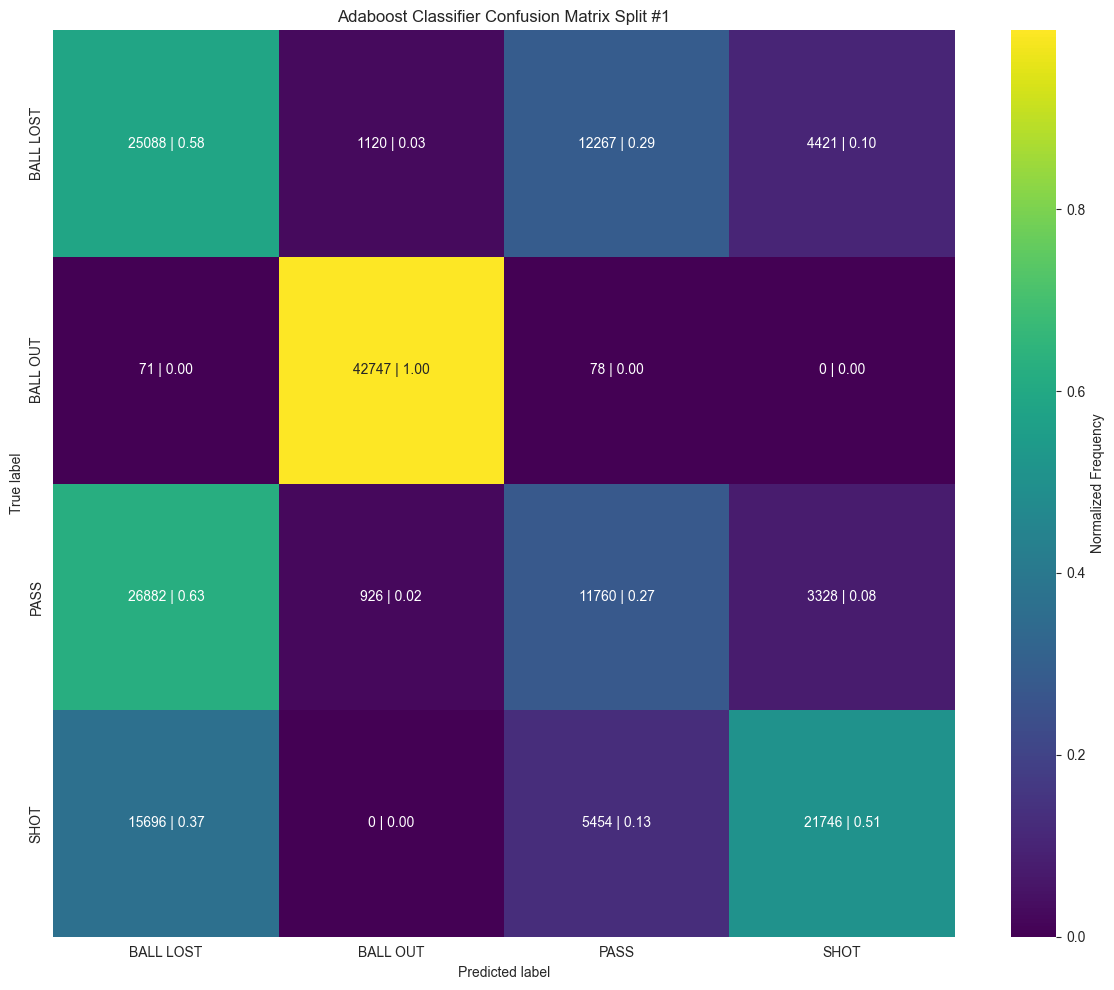

AdaBoost classifier training accuracy: 60.14%
AdaBoost classifier testing accuracy: 59.06%

AdaBoost classifier testing precision: 61.50%
AdaBoost classifier testing recall: 59.06%
AdaBoost classifier testing f1: 58.85%



H:\PAPER\flask-tika\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


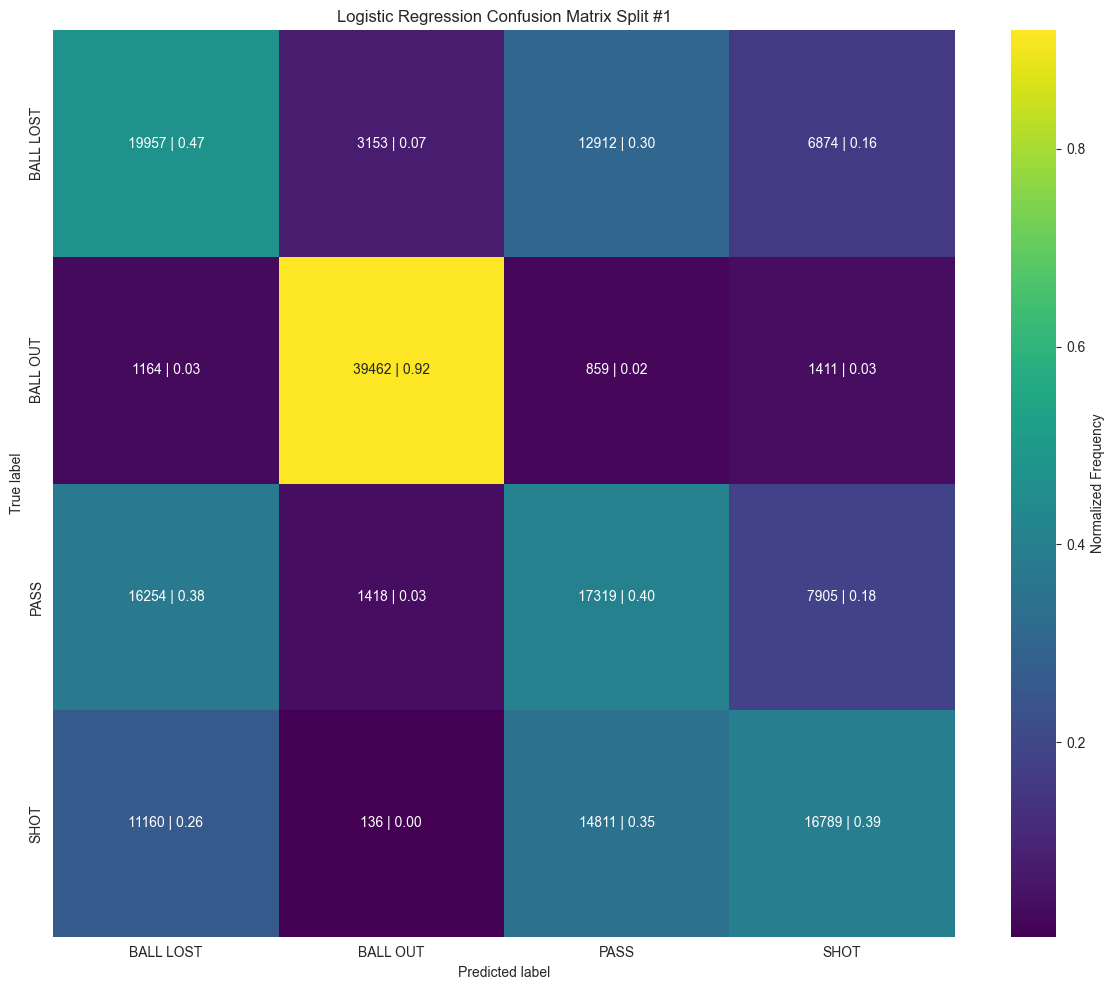

Logistic regression training accuracy: 76.07%
Logistic regression testing accuracy: 54.51%

Logistic regression testing precision: 54.78%
Logistic regression testing recall: 54.51%
Logistic regression testing f1: 54.39%



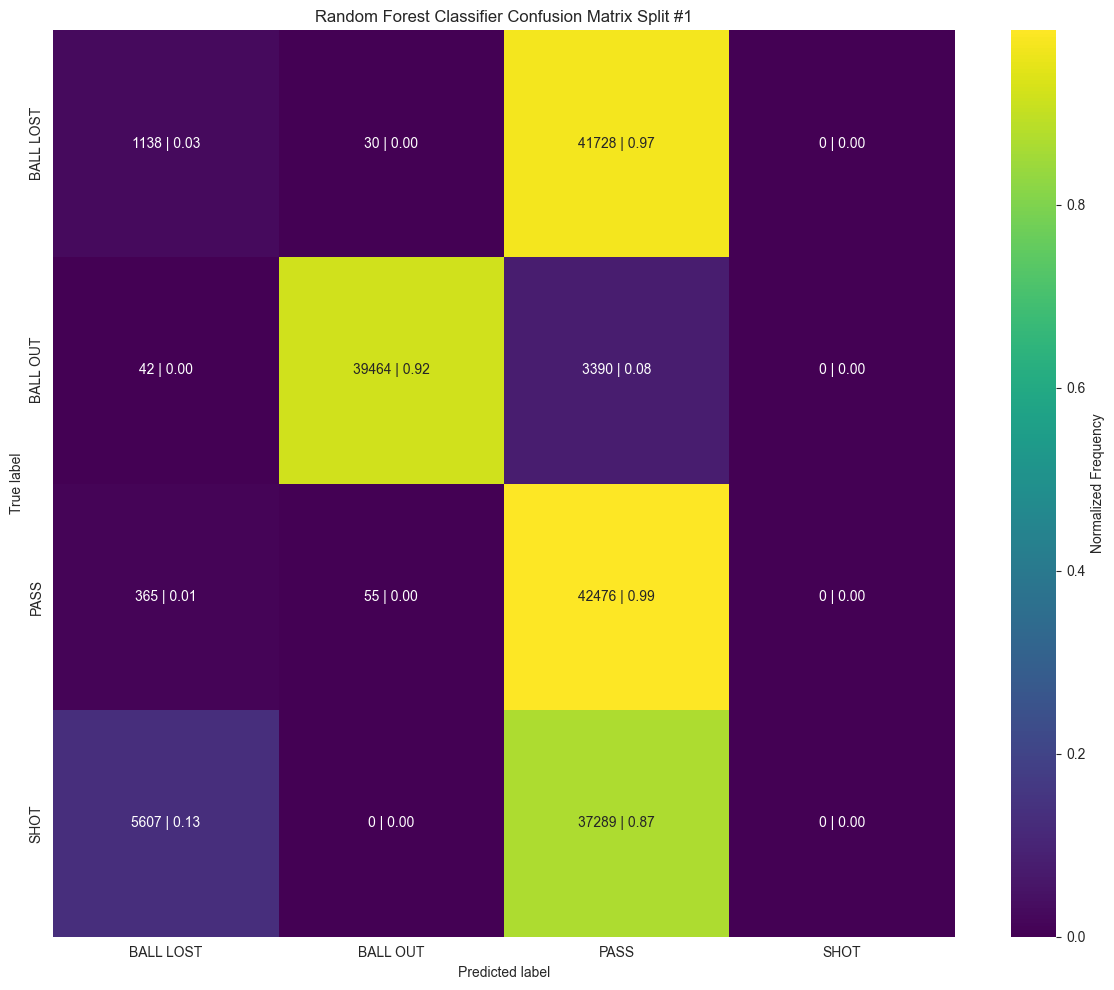

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 48.42%

Random forest classifier testing precision: 37.43%
Random forest classifier testing recall: 48.42%
Random forest classifier testing f1: 37.73%




In [55]:
# 93 with negative direction
# for i in range(len(scaled["X_train"])):
for name, model in models.items():
    # X_train_scaled = scaled["X_train"][0]
    # X_test_scaled = scaled["X_test"][0]
    # y_train = scaled["y_train"][0]
    # y_test = scaled["y_test"][0]

    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_pred = model.predict(X_3_scaled)    
    labels = np.unique(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'])
    
    _ = plot_confusion_matrix(y_train=y, y_train_pred=y_train_pred, y_test=y_3_encoded, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")